In [1]:
import pyro
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, autoguide
import torch
from torch.nn.functional import softplus
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ann
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = ann.read_h5ad("/mnt/storage/thien/projectdata/GSE194122_openproblems_neurips2021_cite_BMMC_processed.h5ad")

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [2]:
# simulate data\n,
n_obs = 100
n_features = 20
n_factors = 5

torch.manual_seed(2024)
Z_in = torch.randn(n_obs, n_factors)
W1_in = torch.randn(n_features, n_factors)
W2_in = torch.randn(n_features, n_factors)

X1 = torch.randn(n_obs, n_features)
X2 = torch.randn(n_obs, n_features)

# create observated values from the simulated factor and weight matrix with some random noise\n,
Y1 = torch.matmul(Z_in, W1_in.t()) + 0.2 * torch.randn(n_obs, n_features)
Y2 = torch.matmul(Z_in, W2_in.t()) + 0.2 * torch.randn(n_obs, n_features)
#print(Y.shape)\n,
#print(Y)\n,


In [7]:
pca1 = PCA(n_components=20)
W1 = pca1.fit_transform(X1)

pca2 = PCA(n_components=20)
W2 = pca2.fit_transform(X2)

cca = CCA(n_components=20)
W1_aligned, W2_aligned = cca.fit_transform(W1, W2)

In [16]:
np.random.seed(42)
X1 = np.random.rand(100, 20)  # Modality 1
X2 = np.random.rand(100, 30)  # Modality 2

# Initialize shared and private components using PCA
n, k = 100, 10  # Number of samples and latent dimensions
pca1 = PCA(n_components=k)
S1_init = pca1.fit_transform(X1)

pca2 = PCA(n_components=k)
S2_init = pca2.fit_transform(X2)

# Initialize S as the average of the two PCA initializations
S = (S1_init + S2_init) / 2
U1 = X1 - S @ np.linalg.pinv(S.T @ S) @ S.T @ X1
U2 = X2 - S @ np.linalg.pinv(S.T @ S) @ S.T @ X2

# Define hyperparameters
lambda_reg = 0.1
num_iterations = 100




In [32]:
(X1 - S @ np.linalg.pinv(S.T @ S) @ S.T @ X1).shape

(100, 20)

In [25]:
U1.shape

(100, 20)

In [15]:
class FA(PyroModule):
    def __init__(self, Y1, Y2, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.Y1 = Y1
        self.Y2 = Y2
        self.K = K
        
        self.num_samples = self.Y1.shape[0]
        self.num_features1 = self.Y1.shape[1]
        self.num_features2 = self.Y2.shape[1]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate1 = pyro.plate("feature1", self.num_features1)
        self.feature_plate2 = pyro.plate("feature2", self.num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                W1 = pyro.sample("W1", pyro.distributions.Normal(0., 1.))  

            with self.feature_plate2:
                # sample weight matrix with Normal prior distribution
                W2 = pyro.sample("W2", pyro.distributions.Normal(0., 1.))               
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y1_hat = torch.matmul(Z, W1.t())
        Y2_hat = torch.matmul(Z, W2.t())
        
        with pyro.plate("feature1_", self.Y1.shape[1]), pyro.plate("sample_", self.Y1.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y1, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y1))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y1 = torch.nan_to_num(self.Y1, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs1", pyro.distributions.Normal(Y1_hat, scale), obs=self.Y1)


        with pyro.plate("feature2_", self.Y2.shape[1]), pyro.plate("sample2_", self.Y2.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y2, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y2))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y2 = torch.nan_to_num(self.Y2, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale2", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs2", pyro.distributions.Normal(Y2_hat, scale), obs=self.Y2)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        guide = autoguide.AutoDelta(self.model)
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        for j in range(num_iterations):
            # calculate the loss and take a gradient step
            loss = svi.step()

            train_loss.append(loss/self.Y1.shape[0])              
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y1.shape[0]))
            
            
        
        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide([Y1])
        
        return train_loss, map_estimates

In [ ]:
PBMC_trainX = torch.utils.data.DataLoader(PBMC_train.X.A, batch_size=128)
PBMC_train, mask = create_mask(PBMC_train, gmt_path= "reactomes.gmt", add_nodes=1)

In [ ]:
PBMC_validX = torch.utils.data.DataLoader(PBMC_valid.X.A, batch_size=128)

def trainVEGA_with_valid(vae, data, val_data, epochs=100, beta = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):
        train_loss_e = 0
        valid_loss_e = 0
        vae.train() #train mode

        for x in data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta* vae.encoder.kl
            loss.backward()
            opt.step()
            train_loss_e += loss.to('cpu').detach().numpy()
            vae.decoder.positive_weights() # we restrict the decoder to positive weights
        train_losses.append(train_loss_e/(len(data)*128))

        #### Here you should add the validation loop
        vae.eval()
        for x in val_data:
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + beta* vae.encoder.kl
            valid_loss_e += loss.to('cpu').detach().numpy()
        valid_losses.append(valid_loss_e/(len(val_data)*128))
        
        print("epoch: ", epoch, " train_loss: ", train_loss_e/(len(data)*128))

        #### print also the validation loss after each epoch!
        print("epoch: ", epoch, " valid_loss: ", valid_loss_e/(len(val_data)*128))
    return vae, train_losses, valid_losses


# model initialization and training
vega = VEGA(latent_dims= mask.shape[1], input_dims = mask.shape[0], mask = mask.T, dropout = 0.3, z_dropout = 0.3).to(device)
vega, train_losses, valid_losses = trainVEGA_with_valid(vega, PBMC_trainX, PBMC_validX, epochs = 50, beta = 0.0001)

In [24]:
from torch.utils.data import DataLoader
X3 = torch.cat((X1, X2), dim=0)
Y3 = torch.cat((Y1, Y2), dim=0)
dat = torch.cat((X3, Y3), dim=0)
train_dataloader = DataLoader(dat[:(int(0.8*dat.shape[1]))], batch_size=1, shuffle=True)
test_dataloader = DataLoader(dat[(int(0.8*dat.shape[1])):], batch_size=1, shuffle=True)

In [26]:
class FA(PyroModule):
    def __init__(self, Y1, Y2, train_dataloader, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.Y1 = Y1
        self.Y2 = Y2
        self.train_dataloader = train_dataloader
        self.K = K
        
        self.num_samples = self.Y1.shape[0]
        self.num_features1 = self.Y1.shape[1]
        self.num_features2 = self.Y2.shape[1]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate1 = pyro.plate("feature", self.num_features1)
        self.feature_plate2 = pyro.plate("feature", self.num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                W1 = pyro.sample("W1", pyro.distributions.Normal(0., 1.))  

            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                W2 = pyro.sample("W2", pyro.distributions.Normal(0., 1.))               
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y1_hat = torch.matmul(Z, W1.t())
        Y2_hat = torch.matmul(Z, W2.t())
        
        with pyro.plate("feature1_", self.Y1.shape[1]), pyro.plate("sample_", self.Y1.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y1, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y1))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y1 = torch.nan_to_num(self.Y1, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs1", pyro.distributions.Normal(Y1_hat, scale), obs=self.Y1)


        with pyro.plate("feature2_", self.Y2.shape[1]), pyro.plate("sample2_", self.Y2.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y2, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y2))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y2 = torch.nan_to_num(self.Y2, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale2", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs2", pyro.distributions.Normal(Y2_hat, scale), obs=self.Y2)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        guide = autoguide.AutoDelta(self.model)
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        test_loss = []
        #for j in range(num_iterations):
        for batchidx, (x, ) in enumerate(self.train_dataloader):
            # calculate the loss and take a gradient step
            loss = svi.step(batchidx)

            train_loss.append(loss/self.Y1.shape[0])
            #with torch.no_grad:
            #    test_loss.append(elbo.loss(self.model, guide, test_data))
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (batchidx + 1, loss / self.Y1.shape[0]))
        
        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide(Y1)
        
        return train_loss, map_estimates

In [16]:
FA_model = FA(Y1, Y2,5)
losses, estimates = FA_model.train()

[iteration 0001] loss: 225.3263
[iteration 0201] loss: 23.5264
[iteration 0401] loss: 17.8712
[iteration 0601] loss: 16.7027
[iteration 0801] loss: 16.3810
[iteration 1001] loss: 16.2827
[iteration 1201] loss: 16.2464
[iteration 1401] loss: 16.2281
[iteration 1601] loss: 16.2239
[iteration 1801] loss: 16.2226


In [85]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

class MultiViewFactorization(nn.Module):
    def __init__(self, num_samples, num_features1, num_features2, num_factors):
        super(MultiViewFactorization, self).__init__()
        self.num_samples = num_samples
        self.num_features1 = num_features1
        self.num_features2 = num_features2
        self.num_factors = num_factors
        
        # Initialize shared latent factors
        self.S = nn.Parameter(torch.randn(num_samples, num_factors))
        
        # Initialize private latent factors for each view
        self.U1 = nn.Parameter(torch.randn(num_features1, num_factors))
        self.U2 = nn.Parameter(torch.randn(num_features2, num_factors))

    def model(self, X1, X2):
        # Priors
        S_prior = dist.Normal(torch.zeros(self.num_samples, self.num_factors), torch.ones(self.num_samples, self.num_factors)).to_event(2)
        U1_prior = dist.Normal(torch.zeros(self.num_features1, self.num_factors), torch.ones(self.num_features1, self.num_factors)).to_event(2)
        U2_prior = dist.Normal(torch.zeros(self.num_features2, self.num_factors), torch.ones(self.num_features2, self.num_factors)).to_event(2)
        
        # Sample from priors
        S = pyro.sample('S', S_prior)
        U1 = pyro.sample('U1', U1_prior)
        U2 = pyro.sample('U2', U2_prior)
        
        # Likelihood
        X1_hat = torch.matmul(S, U1.T)
        X2_hat = torch.matmul(S, U2.T)
        
        with pyro.plate('data1', X1.shape[0]):
            pyro.sample('obs1', dist.Normal(X1_hat, 1.0).to_event(1), obs=X1)
        
        with pyro.plate('data2', X2.shape[0]):
            pyro.sample('obs2', dist.Normal(X2_hat, 1.0).to_event(1), obs=X2)

    def guide(self, X1, X2):
        # Variational distributions
        S_loc = pyro.param('S_loc', torch.randn(self.num_samples, self.num_factors))
        S_scale = pyro.param('S_scale', torch.ones(self.num_samples, self.num_factors), constraint=dist.constraints.positive)
        U1_loc = pyro.param('U1_loc', torch.randn(self.num_features1, self.num_factors))
        U1_scale = pyro.param('U1_scale', torch.ones(self.num_features1, self.num_factors), constraint=dist.constraints.positive)
        U2_loc = pyro.param('U2_loc', torch.randn(self.num_features2, self.num_factors))
        U2_scale = pyro.param('U2_scale', torch.ones(self.num_features2, self.num_factors), constraint=dist.constraints.positive)
        
        S_dist = dist.Normal(S_loc, S_scale).to_event(2)
        U1_dist = dist.Normal(U1_loc, U1_scale).to_event(2)
        U2_dist = dist.Normal(U2_loc, U2_scale).to_event(2)
        
        pyro.sample('S', S_dist)
        pyro.sample('U1', U1_dist)
        pyro.sample('U2', U2_dist)

# Example usage:
num_samples = 100
num_features1 = 20
num_features2 = 30
num_factors = 10
num_iterations = 5000

# Generate synthetic data
X1 = torch.randn(num_samples, num_features1)
X2 = torch.randn(num_samples, num_features2)

# Initialize the model
model = MultiViewFactorization(num_samples, num_features1, num_features2, num_factors)

# Setup the optimizer and the inference algorithm
optimizer = Adam({"lr": 0.02})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

# Train the model
for i in range(num_iterations):
    loss = svi.step(X1, X2)
    if i % 100 == 0:
        print(f"Step {i} : loss = {loss}")

# Get the learned latent factors
S_posterior = pyro.param("S_loc").detach().numpy()
U1_posterior = pyro.param("U1_loc").detach().numpy()
U2_posterior = pyro.param("U2_loc").detach().numpy()

print("Shared components (S):\n", S_posterior)
print("\nPrivate components for view 1 (U1):\n", U1_posterior)
print("\nPrivate components for view 2 (U2):\n", U2_posterior)

Step 0 : loss = 9318.558555603027


Step 100 : loss = 8188.762435913086
Step 200 : loss = 8140.568473815918
Step 300 : loss = 8099.411827087402
Step 400 : loss = 8090.755569458008
Step 500 : loss = 8125.01838684082
Step 600 : loss = 8119.451477050781
Step 700 : loss = 8130.613334655762
Step 800 : loss = 8129.570518493652
Step 900 : loss = 8072.03630065918
Step 1000 : loss = 8095.539978027344
Step 1100 : loss = 8127.798934936523
Step 1200 : loss = 8098.893905639648
Step 1300 : loss = 8076.998802185059
Step 1400 : loss = 8065.0046310424805
Step 1500 : loss = 8054.4304122924805
Step 1600 : loss = 8096.44970703125
Step 1700 : loss = 8083.843765258789
Step 1800 : loss = 8124.302635192871
Step 1900 : loss = 8107.515960693359
Step 2000 : loss = 8127.2685546875
Step 2100 : loss = 8115.371719360352
Step 2200 : loss = 8070.581451416016
Step 2300 : loss = 8083.663627624512
Step 2400 : loss = 8093.483543395996
Step 2500 : loss = 8127.0180740356445
Step 2600 : loss = 8084.9541015625
Step 2700 : loss = 8084.7431640625
Step 2800 : loss

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 0 : loss = 243590.5446
Step 100 : loss = 150250.5604
Step 200 : loss = 142902.5009
Step 300 : loss = 141011.0393
Step 400 : loss = 140425.8809
Step 500 : loss = 140092.1438
Step 600 : loss = 139954.9001
Step 700 : loss = 139929.7815
Step 800 : loss = 139918.1588
Step 900 : loss = 139859.0770
Step 1000 : loss = 139876.7594
Step 1100 : loss = 139833.7688
Step 1200 : loss = 139791.3052
Step 1300 : loss = 139820.4505
Step 1400 : loss = 139841.3021
Step 1500 : loss = 139885.2786
Step 1600 : loss = 139850.6435
Step 1700 : loss = 139884.9763
Step 1800 : loss = 139837.1411
Step 1900 : loss = 139819.0336


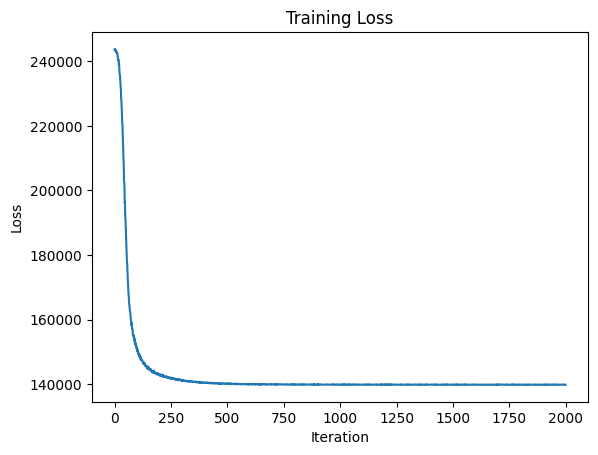

Shared components (S):
 [[-8.63709211e-01  2.09232390e-01  8.24061096e-01 -2.72854328e-01
   1.47850260e-01  2.77108520e-01  1.97326913e-01  1.29438844e-02
  -1.61517859e-01  3.34947288e-01]
 [-1.32977441e-01  6.48378730e-01  2.62418464e-02  8.96589831e-02
   3.44604552e-01  4.55751777e-01  5.83646834e-01  1.22494409e-02
  -5.76646984e-01  5.41932344e-01]
 [-3.79255891e-01 -1.97905675e-01  2.75328249e-01  2.27467835e-01
  -2.19322503e-01  2.75572807e-01  4.43844944e-01  9.24141824e-01
   1.04378068e+00  4.94581342e-01]
 [-3.76625299e-01  7.05389321e-01  4.71491396e-01  5.22026479e-01
  -2.90651888e-01 -5.63940883e-01  4.52707380e-01  2.06001431e-01
   3.10370028e-01 -1.12512540e-02]
 [-1.08770585e+00  1.43921494e-01  6.08203351e-01  8.48506629e-01
  -1.27528101e-01  6.44623786e-02 -2.56117940e-01 -1.21938539e+00
   7.23532200e-01  4.47709322e-01]
 [-1.57225585e+00  1.00532424e+00 -6.80912063e-02 -4.85539466e-01
  -1.90644279e-01  7.15210557e-01  1.89457536e-01 -1.43245652e-01
  -2.6358

In [1]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

class MOFA(nn.Module):
    def __init__(self, num_samples, num_features1, num_features2, num_factors):
        super(MOFA, self).__init__()
        self.num_samples = num_samples
        self.num_features1 = num_features1
        self.num_features2 = num_features2
        self.num_factors = num_factors
        
        # Initialize shared latent factors
        self.S = nn.Parameter(torch.randn(num_samples, num_factors) * 0.01)
        
        # Initialize private latent factors for each view
        self.U1 = nn.Parameter(torch.randn(num_factors, num_features1) * 0.01)
        self.U2 = nn.Parameter(torch.randn(num_factors, num_features2) * 0.01)

    def model(self, X1, X2):
        # Priors
        S_prior = dist.Normal(torch.zeros(self.num_samples, self.num_factors), torch.ones(self.num_samples, self.num_factors)).to_event(2)
        U1_prior = dist.Normal(torch.zeros(self.num_factors, self.num_features1), torch.ones(self.num_factors, self.num_features1)).to_event(2)
        U2_prior = dist.Normal(torch.zeros(self.num_factors, self.num_features2), torch.ones(self.num_factors, self.num_features2)).to_event(2)
        
        # Sample from priors
        S = pyro.sample('S', S_prior)
        U1 = pyro.sample('U1', U1_prior)
        U2 = pyro.sample('U2', U2_prior)
        
        # Likelihood
        X1_hat = torch.matmul(S, U1)
        X2_hat = torch.matmul(S, U2)
        
        with pyro.plate('data1', X1.shape[0]):
            pyro.sample('obs1', dist.Normal(X1_hat, 0.1).to_event(1), obs=X1)
        
        with pyro.plate('data2', X2.shape[0]):
            pyro.sample('obs2', dist.Normal(X2_hat, 0.1).to_event(1), obs=X2)

    def guide(self, X1, X2):
        # Variational distributions
        S_loc = pyro.param('S_loc', torch.randn(self.num_samples, self.num_factors) * 0.01)
        S_scale = pyro.param('S_scale', torch.ones(self.num_samples, self.num_factors) * 0.1, constraint=dist.constraints.positive)
        U1_loc = pyro.param('U1_loc', torch.randn(self.num_factors, self.num_features1) * 0.01)
        U1_scale = pyro.param('U1_scale', torch.ones(self.num_factors, self.num_features1) * 0.1, constraint=dist.constraints.positive)
        U2_loc = pyro.param('U2_loc', torch.randn(self.num_factors, self.num_features2) * 0.01)
        U2_scale = pyro.param('U2_scale', torch.ones(self.num_factors, self.num_features2) * 0.1, constraint=dist.constraints.positive)
        
        S_dist = dist.Normal(S_loc, S_scale).to_event(2)
        U1_dist = dist.Normal(U1_loc, U1_scale).to_event(2)
        U2_dist = dist.Normal(U2_loc, U2_scale).to_event(2)
        
        pyro.sample('S', S_dist)
        pyro.sample('U1', U1_dist)
        pyro.sample('U2', U2_dist)

# Example usage:
num_samples = 100
num_features1 = 20
num_features2 = 30
num_factors = 10
num_iterations = 2000

# Generate synthetic data
X1 = torch.randn(num_samples, num_features1)
X2 = torch.randn(num_samples, num_features2)

# Initialize the model
model = MOFA(num_samples, num_features1, num_features2, num_factors)

# Setup the optimizer and the inference algorithm
optimizer = Adam({"lr": 0.01})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

# Train the model and log loss
losses = []
for i in range(num_iterations):
    loss = svi.step(X1, X2)
    losses.append(loss)
    if i % 100 == 0:
        print(f"Step {i} : loss = {loss:.4f}")

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Get the learned latent factors
S_posterior = pyro.param("S_loc").detach().numpy()
U1_posterior = pyro.param("U1_loc").detach().numpy()
U2_posterior = pyro.param("U2_loc").detach().numpy()

print("Shared components (S):\n", S_posterior)
print("\nPrivate components for view 1 (U1):\n", U1_posterior)
print("\nPrivate components for view 2 (U2):\n", U2_posterior)


Step 0 : loss = 284461.6369
Step 100 : loss = 128097.0005
Step 200 : loss = 111385.5440
Step 300 : loss = 110100.7861
Step 400 : loss = 109631.2777
Step 500 : loss = 109369.3999
Step 600 : loss = 109292.5444
Step 700 : loss = 109184.3082
Step 800 : loss = 109223.9327
Step 900 : loss = 109214.8637
Step 1000 : loss = 109178.8585
Step 1100 : loss = 109195.4989
Step 1200 : loss = 109233.9718
Step 1300 : loss = 109227.2623
Step 1400 : loss = 109224.8215
Step 1500 : loss = 109218.5009
Step 1600 : loss = 109205.0811
Step 1700 : loss = 109218.1890
Step 1800 : loss = 109223.8119
Step 1900 : loss = 109197.0287


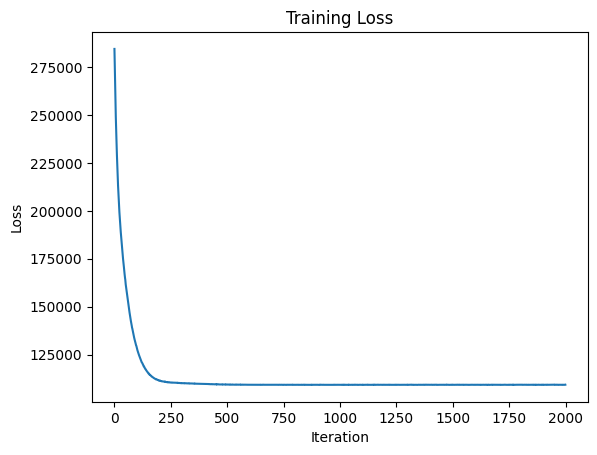

Shared components (S):
 [[ 0.270202    0.324543   -0.11763763 -0.18171152  0.71666175 -0.46586946
   0.5080538  -0.6446638  -0.02063875 -0.35092515]
 [-0.6703211  -0.00394398 -0.506512   -0.8647218   0.6869167   0.40876272
   0.42830703  0.42904523 -0.59121263 -0.10258424]
 [ 0.5656179  -0.42971876  1.1416957   0.6088184   0.6378151  -0.32124695
   0.34172437 -0.0492017  -0.28286263  0.99139327]
 [-0.61353105  0.016013    0.09893162  0.3065984  -1.149986    0.43462688
  -0.27717155 -1.0378842   0.80110544  1.1773438 ]
 [ 0.25696725  0.05606     0.12766148  0.59383655 -0.2125626  -1.3022519
   0.05657695  1.5015812   0.20898569 -0.46292433]
 [ 1.0357586  -0.5954201   0.15558797  0.39823076  1.0237004   0.35263243
  -0.50622046 -0.32096902  0.5001128  -0.22347446]
 [ 0.13707104 -0.14043799  0.5510203  -0.23831147 -0.5194199  -0.06018124
   0.8968282   0.05756795 -0.00446774 -0.4054764 ]
 [ 0.4018113   0.3141261   0.22824551 -1.1143539   0.19328907  0.33778253
   0.4836785  -0.42861053  0

In [9]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

class MOFA(nn.Module):
    def __init__(self, num_samples, num_features1, num_features2, num_factors):
        super(MOFA, self).__init__()
        self.num_samples = num_samples
        self.num_features1 = num_features1
        self.num_features2 = num_features2
        self.num_factors = num_factors
        
        # Initialize shared latent factors
        self.S = nn.Parameter(torch.randn(num_samples, num_factors) * 0.01)
        
        # Initialize private latent factors for each view
        self.U1 = nn.Parameter(torch.randn(num_factors, num_features1) * 0.01)
        self.U2 = nn.Parameter(torch.randn(num_factors, num_features2) * 0.01)

    def model(self, X1, X2):
        # Priors
        S_prior = dist.Normal(torch.zeros(self.num_samples, self.num_factors), torch.ones(self.num_samples, self.num_factors)).to_event(2)
        U1_prior = dist.Normal(torch.zeros(self.num_factors, self.num_features1), torch.ones(self.num_factors, self.num_features1)).to_event(2)
        U2_prior = dist.Normal(torch.zeros(self.num_factors, self.num_features2), torch.ones(self.num_factors, self.num_features2)).to_event(2)
        
        # Sample from priors
        S = pyro.sample('S', S_prior)
        U1 = pyro.sample('U1', U1_prior)
        U2 = pyro.sample('U2', U2_prior)
        
        # Likelihood
        X1_hat = torch.matmul(S, U1)
        X2_hat = torch.matmul(S, U2)
        
        with pyro.plate('data1', X1.shape[0]):
            pyro.sample('obs1', dist.Normal(X1_hat, 0.1).to_event(1), obs=X1)
        
        with pyro.plate('data2', X2.shape[0]):
            pyro.sample('obs2', dist.Normal(X2_hat, 0.1).to_event(1), obs=X2)

    def guide(self, X1, X2):
        # Variational distributions
        S_loc = pyro.param('S_loc', torch.randn(self.num_samples, self.num_factors) * 0.01)
        S_scale = pyro.param('S_scale', torch.ones(self.num_samples, self.num_factors) * 0.1, constraint=dist.constraints.positive)
        U1_loc = pyro.param('U1_loc', torch.randn(self.num_factors, self.num_features1) * 0.01)
        U1_scale = pyro.param('U1_scale', torch.ones(self.num_factors, self.num_features1) * 0.1, constraint=dist.constraints.positive)
        U2_loc = pyro.param('U2_loc', torch.randn(self.num_factors, self.num_features2) * 0.01)
        U2_scale = pyro.param('U2_scale', torch.ones(self.num_factors, self.num_features2) * 0.1, constraint=dist.constraints.positive)
        
        S_dist = dist.Normal(S_loc, S_scale).to_event(2)
        U1_dist = dist.Normal(U1_loc, U1_scale).to_event(2)
        U2_dist = dist.Normal(U2_loc, U2_scale).to_event(2)
        
        pyro.sample('S', S_dist)
        pyro.sample('U1', U1_dist)
        pyro.sample('U2', U2_dist)

# Example usage:
num_samples2 = 100
num_samples = 80
num_features1 = 20
num_features2 = 30
num_factors = 10
num_iterations = 2000

# Generate synthetic data
X1 = torch.randn(num_samples2, num_features1)
X2 = torch.randn(num_samples2, num_features2)

X1_train = X1[:num_samples]
X2_train = X2[:num_samples]
X1_val = X1[num_samples:]
X2_val = X2[num_samples:]

# Initialize the model
model = MOFA(num_samples, num_features1, num_features2, num_factors)

# Setup the optimizer and the inference algorithm
optimizer = Adam({"lr": 0.01})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

# Train the model and log loss
losses = []
val_losses = []
for i in range(num_iterations):
    loss = svi.step(X1_train, X2_train)
    losses.append(loss)
    if i % 100 == 0:
        print(f"Step {i} : loss = {loss:.4f}")
# Plot the loss curve
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# Get the learned latent factors
S_posterior = pyro.param("S_loc").detach().numpy()
U1_posterior = pyro.param("U1_loc").detach().numpy()
U2_posterior = pyro.param("U2_loc").detach().numpy()

print("Shared components (S):\n", S_posterior)
print("\nPrivate components for view 1 (U1):\n", U1_posterior)
print("\nPrivate components for view 2 (U2):\n", U2_posterior)

In [2]:
import pyro
import pyro.distributions as dist
import torch
import torch.nn as nn
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import matplotlib.pyplot as plt

class MOFA(nn.Module):
    def __init__(self, training_size, num_features1, num_features2, num_factors):
        super(MOFA, self).__init__()
        self.training_size = training_size
        self.num_features1 = num_features1
        self.num_features2 = num_features2
        self.num_factors = num_factors

        self.sample_plate = pyro.plate("sample", 80)
        self.feature_plate1 = pyro.plate("feature1", num_features1)
        self.feature_plate2 = pyro.plate("feature2", num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", num_factors)

    def model(self, X1, X2):
        
        num_samples = X1.shape[0]  # Update num_samples based on the current batch size
        print(f"num_samples:{self.training_size}")
        # Priors
        print(f"feature_plate1:{self.feature_plate1}")
        #print(f"feature_plate2:{self.feature_plate2.shape}")
        #print(f"sample_plate:{self.sample_plate.shape}")
        #print(f"latent_factor:{self.latent_factor_plate.shape}")
        with self.latent_factor_plate:
            with self.feature_plate1:
                U1 = pyro.sample("U1", pyro.distributions.Normal(0., 1.))
            with self.feature_plate2:
                U2 = pyro.sample("U2", pyro.distributions.Normal(0., 1.))
        
        with self.latent_factor_plate:
            with self.sample_plate:
                S = pyro.sample("S", pyro.distributions.Normal(0., 1.))
        print(f"S.shape: {S.shape}")

        #S_prior = dist.MultivariateNormal(torch.zeros(self.num_samples, self.num_factors), torch.ones(self.num_samples, self.num_factors))
        #U1_prior = dist.MultivariateNormal(torch.zeros(self.num_factors, self.num_features1), torch.ones(self.num_factors, self.num_features1))
        #U2_prior = dist.MultivariateNormal(torch.zeros(self.num_factors, self.num_features2), torch.ones(self.num_factors, self.num_features2))
        
        # Sample from priors
        #S = pyro.sample('S', S_prior)
        #print(f"S.shape: {S.shape}, S_prior.shape: {S_prior.shape}")
        #U1 = pyro.sample('U1', U1_prior)
        #U2 = pyro.sample('U2', U2_prior)
        #print(f"U1.shape: {U1.shape}, U1_prior.shape: {U1_prior.shape}")
        #print(f"U2.shape: {U2.shape}, U2_prior.shape: {U2_prior.shape}")

        # Likelihood
        X1_hat = torch.matmul(S.T, U1)
        X2_hat = torch.matmul(S.T, U2)

        # Debugging: print shapes
        print(f"X1.shape: {X1.shape}, X1_hat.shape: {X1_hat.shape}")
        print(f"X2.shape: {X2.shape}, X2_hat.shape: {X2_hat.shape}")
        
        with pyro.plate('data1', X1.shape[0]):
            pyro.sample('obs1', dist.Normal(X1_hat, 0.1).to_event(1), obs=X1)
        
        with pyro.plate('data2', X2.shape[0]):
            pyro.sample('obs2', dist.Normal(X2_hat, 0.1).to_event(1), obs=X2)

    def guide(self, X1, X2):
        num_samples = X1.shape[0]  # Update num_samples based on the current batch size

        # Variational distributions

        with self.latent_factor_plate:
            with self.feature_plate1:
                U1_loc = pyro.sample("U1_loc", pyro.distributions.Normal(0., 1.))
            with self.feature_plate2:
                U2_loc = pyro.sample("U2_loc", pyro.distributions.Normal(0., 1.))
        
        with self.latent_factor_plate:
            with self.sample_plate:
                S_loc = pyro.sample("S_loc", pyro.distributions.Normal(0., 1.))

        #S_loc = pyro.param('S_loc', torch.randn(num_samples, self.num_factors) * 0.01)
        S_scale = pyro.param('S_scale', torch.ones(num_samples, self.num_factors) * 0.1, constraint=dist.constraints.positive)
        #U1_loc = pyro.param('U1_loc', torch.randn(self.num_factors, self.num_features1) * 0.01)
        U1_scale = pyro.param('U1_scale', torch.ones(self.num_factors, self.num_features1) * 0.1, constraint=dist.constraints.positive)
        #U2_loc = pyro.param('U2_loc', torch.randn(self.num_factors, self.num_features2) * 0.01)
        U2_scale = pyro.param('U2_scale', torch.ones(self.num_factors, self.num_features2) * 0.1, constraint=dist.constraints.positive)
        
        S_dist = dist.Gamma(S_scale, S_loc)
        U1_dist = dist.Gamma(U1_scale, U1_loc)
        U2_dist = dist.Gamma(U2_scale, U2_loc)
        
        pyro.sample('S', S_dist)
        pyro.sample('U1', U1_dist)
        pyro.sample('U2', U2_dist)

# Example usage:
num_samples = 100
num_features1 = 20
num_features2 = 30
num_factors = 10
num_iterations = 2000

# Generate synthetic data
X1 = torch.randn(num_samples, num_features1)
X2 = torch.randn(num_samples, num_features2)

# Split data into training and validation sets
train_size = int(0.8 * num_samples)
X1_train = X1[:,:train_size]
X2_train = X2[:,:train_size]
X1_val = X1[:,train_size:]
X2_val = X2[:,train_size:]

# Initialize the model with training set size
model = MOFA(train_size, num_features1, num_features2, num_factors)

# Setup the optimizer and the inference algorithm
optimizer = Adam({"lr": 0.01})
svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())

# Training loop with validation loss
train_losses = []
val_losses = []
for i in range(num_iterations):
    # Training step
    train_loss = svi.step(X1_train, X2_train)
    train_losses.append(train_loss)
    
    # Validation step
    with torch.no_grad():
        val_loss = svi.evaluate_loss(X1_val, X2_val)
        val_losses.append(val_loss)
    
    # Print losses every 100 iterations
    if i % 100 == 0:
        print(f"Step {i} : train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

# Plot the training and validation loss curves
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Get the learned latent factors
S_posterior = pyro.param("S_loc").detach().numpy()
U1_posterior = pyro.param("U1_loc").detach().numpy()
U2_posterior = pyro.param("U2_loc").detach().numpy()

print("Shared components (S):\n", S_posterior)
print("\nPrivate components for view 1 (U1):\n", U1_posterior)
print("\nPrivate components for view 2 (U2):\n", U2_posterior)

RuntimeError: The size of tensor a (100) must match the size of tensor b (80) at non-singleton dimension 0
Trace Shapes:          
 Param Sites:          
      S_scale    100 10
     U1_scale     10 20
     U2_scale     10 30
Sample Sites:          
  U1_loc dist 20  10  |
        value 20  10  |
  U2_loc dist 30  10  |
        value 30  10  |
   S_loc dist 80  10  |
        value 80  10  |

In [18]:
class FA(PyroModule):
    def __init__(self, Y1, Y2, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.Y1 = Y1
        self.Y2 = Y2
        self.K = K
        
        self.num_samples = self.Y1.shape[0]
        self.num_features1 = self.Y1.shape[1]
        self.num_features2 = self.Y2.shape[1]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate1 = pyro.plate("feature1", self.num_features1)
        self.feature_plate2 = pyro.plate("feature2", self.num_features2)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate1:
                # sample weight matrix with Normal prior distribution
                W1 = pyro.sample("W1", pyro.distributions.Normal(0., 1.))
            with self.feature_plate2:
                W2 = pyro.sample("W2", pyro.distributions.Normal(0., 1.))                
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y1_hat = torch.matmul(Z, W1.t())
        Y2_hat = torch.matmul(Z, W2.t())
        
        with pyro.plate("feature1_", self.Y1.shape[1]), pyro.plate("sample1_", self.Y1.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs1_mask = torch.ones_like(self.Y1, dtype=torch.bool)
            if data is not None:
                obs1_mask = torch.logical_not(torch.isnan(self.Y1))
            with pyro.poutine.mask(mask=obs1_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y1 = torch.nan_to_num(self.Y1, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale1 = pyro.sample("scale1", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs1", pyro.distributions.Normal(Y1_hat, scale1), obs=self.Y1)
        
        with pyro.plate("feature2_", self.Y2.shape[1]), pyro.plate("sample2_", self.Y2.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs2_mask = torch.ones_like(self.Y2, dtype=torch.bool)
            if data is not None:
                obs2_mask = torch.logical_not(torch.isnan(self.Y2))
            with pyro.poutine.mask(mask=obs2_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y2 = torch.nan_to_num(self.Y2, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale2 = pyro.sample("scale2", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs2", pyro.distributions.Normal(Y2_hat, scale2), obs=self.Y2)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        guide = autoguide.AutoDelta(self.model)
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        val_losses = []
        for j in range(num_iterations):
            # calculate the loss and take a gradient step
            #print(torch.cat((X1_train.T, X2_train.T), dim=0))
            loss = svi.step()

            train_loss.append(loss/self.Y1.shape[0])
            with torch.no_grad():
                val_loss = svi.evaluate_loss(X1_val, X2_val)
                val_losses.append(val_loss)
    
            # Print losses every 100 iterations
            if j % 100 == 0:
                print(f"Step {j} : train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")
            #if j % 200 == 0:
            #    print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y1.shape[0]))
        
        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide(Y1, Y2)
        
        return train_loss, map_estimates

In [19]:
num_samples = 100
num_features1 = 20
num_features2 = 20
num_factors = 10
num_iterations = 2000

# Generate synthetic data
X1 = torch.randn(num_samples, num_features1)
X2 = torch.randn(num_samples, num_features2)

# Split data into training and validation sets
train_size = int(0.8 * num_samples)
X1_train = X1[:,:train_size]
X2_train = X2[:,:train_size]
X1_val = X1[:,train_size:]
X2_val = X2[:,train_size:]


FA_model = FA(X1_train, X2_train,10)
losses, estimates = FA_model.train()

/home/thien/.local/lib/python3.8/site-packages/pyro/util.py:365: UserWarning: Found plate statements in guide but not model: {'feature1', 'sample', 'feature2', 'latent factors'}
  warnings.warn(


TypeError: model() takes 1 positional argument but 3 were given

In [13]:
torch.cat((X1_train.T, X2_train.T), dim=0)

tensor([[-1.1911, -0.7829,  0.3724,  ...,  0.7869, -0.7921,  0.3925],
        [ 1.0133,  0.4645,  0.2023,  ..., -0.2167,  0.6153, -0.0137],
        [-0.3000,  0.6149, -0.3839,  ..., -0.9911, -0.3520, -0.9197],
        ...,
        [-0.6997, -0.9290,  0.9005,  ..., -0.9129, -0.8621,  1.3675],
        [-1.4562,  0.1489, -1.5442,  ...,  0.1230,  1.2073, -0.8714],
        [ 1.1323,  0.6291,  1.0210,  ...,  0.7032,  0.2642,  0.3194]])